In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data

In [3]:
# generate data for grid network (features and costs)
m = 32 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 2 # dimension of knapsack
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim)

In [4]:
weights

array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7.83, 5.64, 7.56, 3.28, 4.31, 3.85, 6.43, 4.26, 7.56, 6.4 ],
       [6.09, 6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27,
        4.55, 5.64, 5.66, 3.27, 6.68, 4.2 , 5.61, 6.13, 7.88, 4.61, 4.92,
        6.09, 7.95, 7.11, 4.02, 3.07, 7.84, 6.29, 5.78, 5.57, 5.65]])

In [5]:
# convert max into min
c = - c

## Optimization Model 

In [6]:
# capacity
caps = [20] * dim

In [7]:
ks_model = pyepo.model.grb.knapsackModel(weights, caps)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-03-06


In [8]:
# solve
ks_model.setObj([-i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
Obj: -111.0
25
26
29
31


In [9]:
# relax
ks_model_rel = ks_model.relax()

In [10]:
# solve
ks_model_rel.setObj([-i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08748512880277728, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.18843324349916252, 1.0]
Obj: -118.4901850098332
21
25
26
29
30
31


## Data Loader 

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [12]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [13]:
# get training data set
ks_dataset_train = pyepo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 348.35it/s]


In [14]:
# get training data set for relaxation
ks_dataset_train_rel = pyepo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1408.13it/s]


In [15]:
# get test data set
ks_dataset_test = pyepo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.74it/s]


In [16]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [17]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [18]:
x.shape

torch.Size([32, 5])

In [19]:
c.shape

torch.Size([32, 32])

In [20]:
w.shape

torch.Size([32, 32])

In [21]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [24]:
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [25]:
# training
twostage_model.fit(ks_dataset_train.feats, ks_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [26]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.feats)

In [27]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += pyepo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.75it/s]


Normalized true SPO Loss: 2.39%
Normalized unambiguous SPO Loss: 2.39%


In [28]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 1.00, 4.00, 4.00, 1.00, 1.00, 1.00, 1.00, 3.00, 1.00, 4.00, 3.00, 1.00, 1.00, 1.00, 3.00, 1.00, 3.00, 3.00, 1.00, 3.00, 3.00, 1.00, 4.00, 1.00, 1.00, 1.00, 4.00, 3.00, 4.00, 1.00, 4.00, 4.00
    Pred cost: 0.15, 4.89, 3.49, -1.84, -1.56, -0.78, 0.32, 3.85, 0.32, 5.22, 3.60, 0.15, -1.75, -1.56, 3.60, -1.27, 3.97, 3.00, -1.84, 3.62, 3.85, 0.29, 4.28, -1.28, -0.78, -1.28, 4.82, 3.78, 4.28, -1.84, 4.28, 5.03
    True sol: 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, True obj: 16.00
    Pred sol: -0, -0, 0, 0, 0, 0, -0, -0, -0, 1, -0, -0, 0, 0, 0, 0, -0, -0, 0, -0, 1, -0, -0, 0, 0, 0, 1, -0, -0, 0, -0, 1, Pred obj: 15.00

Sample 1:
    True cost: 4.00, 2.00, 8.00, 2.00, 1.00, 2.00, 5.00, 3.00, 5.00, 3.00, 6.00, 4.00, 2.00, 1.00, 6.00, 4.00, 2.00, 3.00, 2.00, 2.00, 3.00, 3.00, 3.00, 6.00, 2.00, 6.00, 6.00, 4.00, 3.00, 2.00, 3.00, 7.00
    Pred cost: 5.01, 1.68, 7.28, 3.29, 0.45, 1.74, 7.01, 3.95, 7.01, 4.27, 5.85, 5.

## Two-Stage with Grid Search 

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [30]:
# build model
twostage_model = pyepo.twostage.sklearnPred(Ridge())

In [31]:
# creat scorer
spo_scorer = pyepo.eval.metrics.makeSkScorer(ks_model)

In [32]:
# build grid search
grid = GridSearchCV(twostage_model, param_grid={'estimator__alpha': [0, 0.1, 0.5]}, scoring=spo_scorer)

In [33]:
# training
grid.fit(ks_dataset_train.feats, ks_dataset_train.costs)

GridSearchCV(estimator=MultiOutputRegressor(estimator=Ridge()),
             param_grid={'estimator__alpha': [0, 0.1, 0.5]},
             scoring=make_scorer(SPOError, greater_is_better=False, model_type=<class 'pyepo.model.grb.knapsack.knapsackModel'>, args={'weights': array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7.83, 5.64, 7.56, 3.28, 4.31, 3.85, 6.43, 4.26, 7.56, 6.4 ],
       [6.09, 6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27,
        4.55, 5.64, 5.66, 3.27, 6.68, 4.2 , 5.61, 6.13, 7.88, 4.61, 4.92,
        6.09, 7.95, 7.11, 4.02, 3.07, 7.84, 6.29, 5.78, 5.57, 5.65]]), 'capacity': array([20, 20])}))

In [34]:
# prediction
c_test_pred = grid.predict(ks_dataset_test.feats)

In [35]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += pyepo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.21it/s]


Normalized true SPO Loss: 2.39%
Normalized unambiguous SPO Loss: 2.39%


In [36]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = grid.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 1.00, 4.00, 4.00, 1.00, 1.00, 1.00, 1.00, 3.00, 1.00, 4.00, 3.00, 1.00, 1.00, 1.00, 3.00, 1.00, 3.00, 3.00, 1.00, 3.00, 3.00, 1.00, 4.00, 1.00, 1.00, 1.00, 4.00, 3.00, 4.00, 1.00, 4.00, 4.00
    Pred cost: 0.15, 4.89, 3.49, -1.84, -1.56, -0.78, 0.32, 3.85, 0.32, 5.22, 3.60, 0.15, -1.75, -1.56, 3.60, -1.27, 3.97, 3.00, -1.84, 3.62, 3.85, 0.29, 4.28, -1.28, -0.78, -1.28, 4.82, 3.78, 4.28, -1.84, 4.28, 5.03
    True sol: 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, True obj: 16.00
    Pred sol: -0, -0, 0, 0, 0, 0, -0, -0, -0, 1, -0, -0, 0, 0, 0, 0, -0, -0, 0, -0, 1, -0, -0, 0, 0, 0, 1, -0, -0, 0, -0, 1, Pred obj: 15.00

Sample 1:
    True cost: 4.00, 2.00, 8.00, 2.00, 1.00, 2.00, 5.00, 3.00, 5.00, 3.00, 6.00, 4.00, 2.00, 1.00, 6.00, 4.00, 2.00, 3.00, 2.00, 2.00, 3.00, 3.00, 3.00, 6.00, 2.00, 6.00, 6.00, 4.00, 3.00, 2.00, 3.00, 7.00
    Pred cost: 5.01, 1.68, 7.28, 3.29, 0.45, 1.74, 7.01, 3.95, 7.01, 4.27, 5.85, 5.

## Linear Regression from PyTorch

In [37]:
from torch import nn

In [38]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [39]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [40]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [41]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [42]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  12.7498, True SPO Loss: 37.4793%, Unambiguous SPO Loss: 37.4793%
Epoch  20, Loss:  20.8584, True SPO Loss: 32.5182%, Unambiguous SPO Loss: 32.5182%
Epoch  30, Loss:  22.0055, True SPO Loss: 28.2865%, Unambiguous SPO Loss: 28.2901%
Epoch  40, Loss:  29.5691, True SPO Loss: 22.8780%, Unambiguous SPO Loss: 22.8780%
Epoch  50, Loss:  25.2960, True SPO Loss: 18.9669%, Unambiguous SPO Loss: 18.9669%
Epoch  60, Loss:   6.3717, True SPO Loss: 16.0565%, Unambiguous SPO Loss: 16.0565%
Epoch  70, Loss:  16.0113, True SPO Loss: 12.4908%, Unambiguous SPO Loss: 12.4908%
Epoch  80, Loss:   5.8407, True SPO Loss: 10.3027%, Unambiguous SPO Loss: 10.3027%
Epoch  90, Loss:   4.7035, True SPO Loss:  8.2802%, Unambiguous SPO Loss:  8.2802%
Epoch 100, Loss:  12.8421, True SPO Loss:  6.6206%, Unambiguous SPO Loss:  6.6206%
Epoch 110, Loss:   1.2445, True SPO Loss:  5.7644%, Unambiguous SPO Loss:  5.7644%
Epoch 120, Loss:   7.1293, True SPO Loss:  4.5876%, Unambiguous SPO Loss:  4.5876%
Epoc

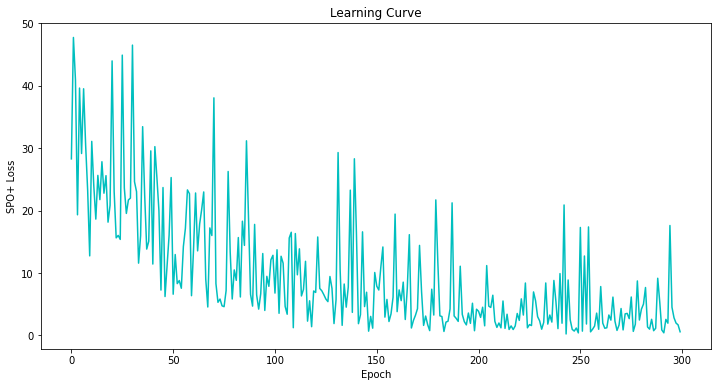

In [43]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

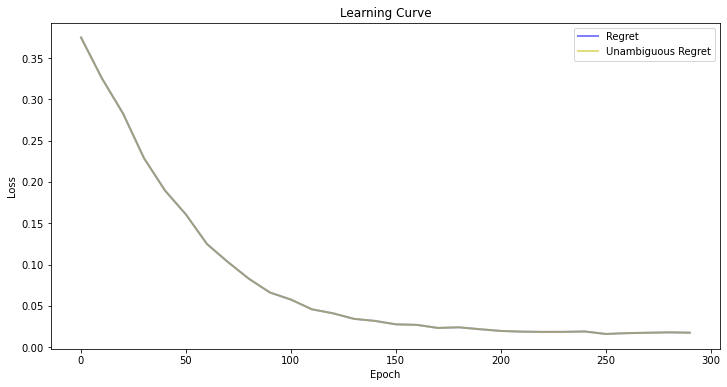

In [44]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='b', alpha=0.5, lw=2, label='Regret')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='y', alpha=0.5, lw=2, label='Unambiguous Regret')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [45]:
# evaluate
spoloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 1.76%
Normalized unambiguous SPO Loss: 1.76%


In [46]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 1.00, 4.00, 4.00, 1.00, 1.00, 1.00, 1.00, 3.00, 1.00, 4.00, 3.00, 1.00, 1.00, 1.00, 3.00, 1.00, 3.00, 3.00, 1.00, 3.00, 3.00, 1.00, 4.00, 1.00, 1.00, 1.00, 4.00, 3.00, 4.00, 1.00, 4.00, 4.00
    Pred cost: 1.04, 4.26, 3.47, -1.12, -1.54, -0.99, 0.33, 3.46, -1.34, 5.06, 3.42, 1.34, -1.00, -2.05, 3.46, -0.03, 3.40, 2.95, -0.54, 5.29, 3.77, -0.63, 2.07, -0.68, -0.91, -0.84, 4.83, 3.53, 4.65, -1.15, 4.56, 5.29
    True sol: 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, True obj: 16.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 15.00

Sample 1:
    True cost: 4.00, 2.00, 8.00, 2.00, 1.00, 2.00, 5.00, 3.00, 5.00, 3.00, 6.00, 4.00, 2.00, 1.00, 6.00, 4.00, 2.00, 3.00, 2.00, 2.00, 3.00, 3.00, 3.00, 6.00, 2.00, 6.00, 6.00, 4.00, 3.00, 2.00, 3.00, 7.00
    Pred cost: 3.15, -0.58, 5.23, -0.69, -2.03, -1.13, 4.39, 2.34, 4.02, 1.87, 4.10, 3.31, 0.50,

## SPO+ Rel 

In [47]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [48]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [49]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(ks_model_rel, processes=4)

Num of cores: 4


In [50]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  33.5422, True SPO Loss: 39.3573%, Unambiguous SPO Loss: 39.3573%
Epoch  20, Loss:  14.1541, True SPO Loss: 34.1919%, Unambiguous SPO Loss: 34.1919%
Epoch  30, Loss:  20.9577, True SPO Loss: 30.2174%, Unambiguous SPO Loss: 30.2174%
Epoch  40, Loss:  21.6979, True SPO Loss: 27.0286%, Unambiguous SPO Loss: 27.0286%
Epoch  50, Loss:  37.8631, True SPO Loss: 24.1147%, Unambiguous SPO Loss: 24.1147%
Epoch  60, Loss:  18.9935, True SPO Loss: 20.2988%, Unambiguous SPO Loss: 20.2988%
Epoch  70, Loss:  15.8525, True SPO Loss: 18.2340%, Unambiguous SPO Loss: 18.2340%
Epoch  80, Loss:  17.6723, True SPO Loss: 16.8810%, Unambiguous SPO Loss: 16.8810%
Epoch  90, Loss:  40.9979, True SPO Loss: 15.5527%, Unambiguous SPO Loss: 15.5527%
Epoch 100, Loss:  41.6426, True SPO Loss: 13.4033%, Unambiguous SPO Loss: 13.4033%
Epoch 110, Loss:  16.3674, True SPO Loss: 11.5112%, Unambiguous SPO Loss: 11.5112%
Epoch 120, Loss:  15.8310, True SPO Loss: 10.4824%, Unambiguous SPO Loss: 10.4824%
Epoc

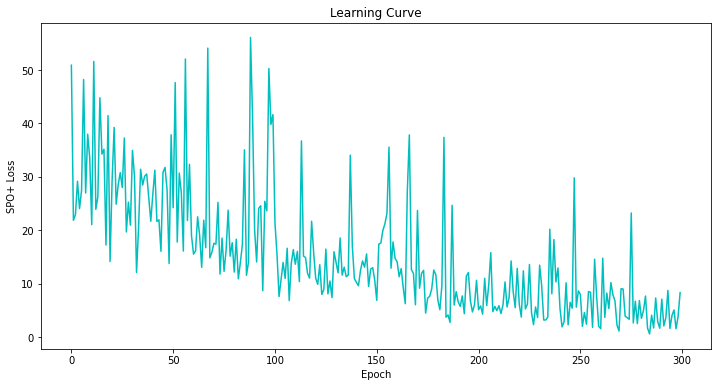

In [51]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

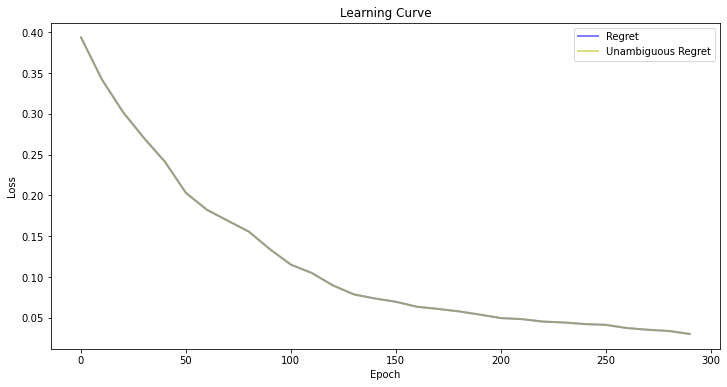

In [52]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='b', alpha=0.5, lw=2, label='Regret')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='y', alpha=0.5, lw=2, label='Unambiguous Regret')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [53]:
# evaluate
spoloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 3.01%
Normalized unambiguous SPO Loss: 3.01%


In [54]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 1.00, 4.00, 4.00, 1.00, 1.00, 1.00, 1.00, 3.00, 1.00, 4.00, 3.00, 1.00, 1.00, 1.00, 3.00, 1.00, 3.00, 3.00, 1.00, 3.00, 3.00, 1.00, 4.00, 1.00, 1.00, 1.00, 4.00, 3.00, 4.00, 1.00, 4.00, 4.00
    Pred cost: 1.50, 3.70, 2.85, -0.72, -0.50, -0.27, 0.54, 2.34, 0.11, 3.79, 2.82, 0.48, -0.01, -0.92, 2.63, -0.57, 2.73, 2.37, -0.37, 2.54, 3.14, -0.20, 2.69, -1.10, 0.25, -0.68, 3.73, 1.88, 2.98, -0.47, 2.91, 3.14
    True sol: 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, True obj: 16.00
    Pred sol: 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, Pred obj: 15.00

Sample 1:
    True cost: 4.00, 2.00, 8.00, 2.00, 1.00, 2.00, 5.00, 3.00, 5.00, 3.00, 6.00, 4.00, 2.00, 1.00, 6.00, 4.00, 2.00, 3.00, 2.00, 2.00, 3.00, 3.00, 3.00, 6.00, 2.00, 6.00, 6.00, 4.00, 3.00, 2.00, 3.00, 7.00
    Pred cost: 2.30, 0.20, 3.85, -0.45, -1.31, 0.20, 3.15, 0.64, 2.99, 1.56, 3.10, 0.89, 0.73, -1.

## Black-Box

In [55]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [56]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [57]:
# set loss
bb = pyepo.func.blackboxOpt(ks_model, lambd=20, processes=4)
criterion = nn.L1Loss()

Num of cores: 4


In [58]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   5.5000, True SPO Loss: 15.7500%, Unambiguous SPO Loss: 15.7500%
Epoch  20, Loss:   0.0000, True SPO Loss:  5.6376%, Unambiguous SPO Loss:  5.6376%
Epoch  30, Loss:   0.0000, True SPO Loss:  4.4537%, Unambiguous SPO Loss:  4.4537%
Epoch  40, Loss:   0.0000, True SPO Loss:  4.2564%, Unambiguous SPO Loss:  4.2564%
Epoch  50, Loss:   0.0000, True SPO Loss:  4.2176%, Unambiguous SPO Loss:  4.2176%
Epoch  60, Loss:   0.0000, True SPO Loss:  3.8124%, Unambiguous SPO Loss:  3.8124%
Epoch  70, Loss:   0.0000, True SPO Loss:  3.8970%, Unambiguous SPO Loss:  3.8970%
Epoch  80, Loss:   0.0000, True SPO Loss:  3.9075%, Unambiguous SPO Loss:  3.9075%
Epoch  90, Loss:   0.0000, True SPO Loss:  3.8336%, Unambiguous SPO Loss:  3.8336%
Epoch 100, Loss:   0.0000, True SPO Loss:  3.9393%, Unambiguous SPO Loss:  3.9393%
Epoch 110, Loss:   0.0000, True SPO Loss:  3.8371%, Unambiguous SPO Loss:  3.8371%
Epoch 120, Loss:   0.0000, True SPO Loss:  3.8371%, Unambiguous SPO Loss:  3.8371%
Epoc

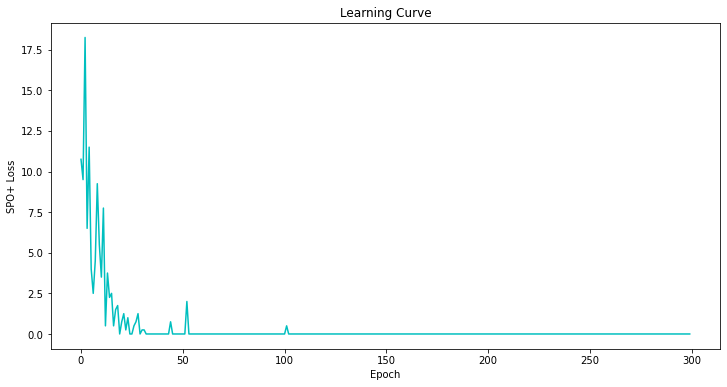

In [59]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

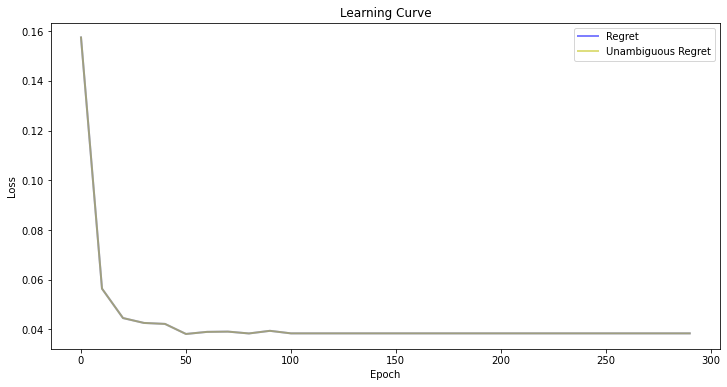

In [60]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='b', alpha=0.5, lw=2, label='Regret')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='y', alpha=0.5, lw=2, label='Unambiguous Regret')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [61]:
# evaluate
spoloss = pyepo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = pyepo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 3.84%
Normalized unambiguous SPO Loss: 3.84%


In [62]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 1.00, 4.00, 4.00, 1.00, 1.00, 1.00, 1.00, 3.00, 1.00, 4.00, 3.00, 1.00, 1.00, 1.00, 3.00, 1.00, 3.00, 3.00, 1.00, 3.00, 3.00, 1.00, 4.00, 1.00, 1.00, 1.00, 4.00, 3.00, 4.00, 1.00, 4.00, 4.00
    Pred cost: -0.30, 0.37, 0.21, -0.20, -1.15, -1.06, 0.01, 0.37, -0.48, 1.28, 0.21, -0.25, -0.92, -0.60, 0.18, -0.41, 0.28, 0.32, -0.82, 0.61, 0.81, -0.22, 0.56, -0.01, -0.74, -0.92, 0.72, 0.06, 0.60, -1.28, 0.94, 0.35
    True sol: 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, True obj: 16.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, Pred obj: 15.00

Sample 1:
    True cost: 4.00, 2.00, 8.00, 2.00, 1.00, 2.00, 5.00, 3.00, 5.00, 3.00, 6.00, 4.00, 2.00, 1.00, 6.00, 4.00, 2.00, 3.00, 2.00, 2.00, 3.00, 3.00, 3.00, 6.00, 2.00, 6.00, 6.00, 4.00, 3.00, 2.00, 3.00, 7.00
    Pred cost: 0.64, -0.08, 1.11, 0.08, -0.76, -1.39, 0.83, -0.36, 0.65, 0.13, 0.82, 0.26, -0.